In [1]:
# import tsfresh

In [2]:
import numpy as np
import shap
n_features = 'all'
# data_file_name = 'data_for_training_tsfeatures_models'
data_file_name = 'merged_data_for_training_tsfeatures_models_expanded_var_2_4'

endpt = 17
eval_times = np.r_[np.arange(1, endpt+1, 1)]
training_id_file_name = 'all_training_set_ID_2'
validation_id_file_name = 'all_validation_set_ID_2'
testing_id_file_name = 'all_testing_set_ID_2'
#work_dir = '/home/idies/workspace/Storage/hnguye78/persistent/CARDIA_longi_project/'
work_dir = 'U:/Hieu/CARDIA_longi_project/'

In [3]:
# %pip install plotly
# %pip install tensorflow
# %pip install lifelines

#!y | pip uninstall statsmodels 
# %pip install statsmodels==0.11.0

# %pip install keras

In [4]:
import pkg_resources
#pkg_resources.require("scikit-learn==1.0.2")
import sklearn

import sksurv

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from numpy.random import seed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

In [5]:
load_dir = work_dir+ '/csv_files'

# load data:
data_full = pd.read_csv(load_dir+'/'+data_file_name+'.csv')
data_full = data_full.select_dtypes(include =[np.number])



In [6]:
# load training id:
loaddir = work_dir+ '/csv_files'
trainingid_all = pd.read_csv(loaddir+'/'+training_id_file_name+'.csv')
validationid_all = pd.read_csv(loaddir+'/'+validation_id_file_name+'.csv')
testingid_all = pd.read_csv(loaddir+'/'+testing_id_file_name+'.csv')


## no need to standardize feature space since RSF can handle it, then merge back to label space:
feature_space = data_full.drop(['ID','event','time'], axis = 1)
feature_name_list = feature_space.columns.values


In [7]:
data_full

ID  event       time  MALE  RACEBLACK  ARMCI  ASMA  BEER  \
0     100033323702      0  17.134155     1          0   35.0     0     0   
1     100056526386      0  17.142368     1          1   36.0     0     1   
2     100061300991      0  17.427105     1          1   35.0     0     8   
3     100080112533      0  17.057495     1          1   33.0     0     0   
4     100101126081      0  17.424367     0          1   50.0     0     0   
...            ...    ...        ...   ...        ...    ...   ...   ...   
3534  416752023336      0  16.704312     1          1   33.0     0     0   
3535  416761219907      0  16.674196     0          0   29.0     0     0   
3536  416783315386      0  16.690623     0          0   25.5     0     0   
3537  416796224310      0  16.761807     0          1   41.5     1     0   
3538  416817227898      0  16.770021     1          1   37.5     0    16   

            BMI  CANCR  ...  \
0     25.680330      0  ...   
1     30.218171      0  ...   
2     30.062319      0  ...   
3     22.747420      0  ...   
4     39.548526      0  ...   
...         ...    ...  ...   
3534  26.210050      0  ...   
3535  25.692550      0  ...   
3536  20.409280      0  ...   
3537  40.326230      0  ...   
3538  28.885950      0  ...   

      DIAB__cwt_coefficients__coeff_1__w_10__widths_.2..5..10..20.  \
0                                                   0.0              
1                                                   0.0              
2                                                   0.0              
3                                                   0.0              
4                                                   0.0              
...                                                 ...              
3534                                                0.0              
3535                                                0.0              
3536                                                0.0              
3537                                                0.0              
3538                                                0.0              

      HBM__change_quantiles__f_agg_.var.__isabs_True__qh_0.4__ql_0.2  \
0                                                   0.0                
1                                                   0.0                
2                                                   0.0                
3                                                   0.0                
4                                                   0.0                
...                                                 ...                
3534                                                0.0                
3535                                                0.0                
3536                                                0.0                
3537                                                0.0                
3538                                                0.0                

      HBM__minimum  \
0                0   
1                0   
2                0   
3                0   
4                0   
...            ...   
3534             0   
3535             0   
3536             0   
3537             0   
3538             0   

      DIAB__percentage_of_reoccurring_datapoints_to_all_datapoints  \
0                                                   1.0              
1                                                   1.0              
2                                                   1.0              
3                                                   1.0              
4                                                   1.0              
...                                                 ...              
3534                                                1.0              
3535                                                1.0              
3536                                                1.0              
3537                                                1.0    

In [8]:
def f_rsf_input_as_matrix(X):
    surv = rsf.predict_survival_function(X, return_array=True)
    last_yr_pred_prob_surv=surv[:,-1]
    return last_yr_pred_prob_surv


def vimp_shap_tabular(feature_names, vals):
    feature_importance_df = pd.DataFrame(list(zip(feature_names, vals)), columns=['variable_name','vimp'])
    feature_importance_df.sort_values(by=['vimp'], ascending=False,inplace=True)
    feature_importance_df['normalized_vimp'] = (feature_importance_df['vimp'] - min(feature_importance_df['vimp']))/(max(feature_importance_df['vimp'])-min(feature_importance_df['vimp']))
    
   # merge with variable description:
   # var_dict = pd.read_csv(load_dir+'/y5_all_vars_dictionary_manually_selecting_vars (3).csv', encoding= 'unicode_escape')
   # var_dict[['Variable.Name', 'Variable.Label']]
    ## merge vimp table with var dict to get var description:
    # feature_importance_df_with_vardes = feature_importance_df.merge(
    #    var_dict[['Variable.Name', 'Variable.Label']], how = 'inner', right_on= 'Variable.Name', left_on = 'variable_name', copy= False)
    return(feature_importance_df[['variable_name','normalized_vimp','vimp']])


In [9]:
# Outerloop:
c_index = np.zeros((25,1))
# for fold in range(25):

## 
fold = 0
print('')
print('FOLD '+str(fold)+':')
print('')

# trainingid = trainingid_all.iloc[:,fold]
# trainingid = trainingid[~np.isnan(trainingid)]

trainingid = trainingid_all.iloc[:,fold].values
validationid = validationid_all.iloc[:,fold].values
testingid = testingid_all.iloc[:,fold].values

training_validation_id = np.concatenate([trainingid,validationid])
#training_validation_id = training_validation_id[~np.isnan(training_validation_id)]
#testingid = testingid[~np.isnan(testingid)]

#eligible_id = data_full['ID'][data_full['ID'].isin(training_validation_id)]
train_df = data_full.loc[data_full['ID'].isin(training_validation_id),:]
del train_df['ID']
test_df = data_full.loc[data_full['ID'].isin(testingid),:]
del test_df['ID']

featurespace_train_df = train_df.drop(['time','event'],axis =1)
featurespace_test_df = test_df.drop(['time','event'],axis =1)

featurespace_train = train_df.drop(['time','event'],axis =1).values
featurespace_test = test_df.drop(['time','event'],axis =1).values

y_train = sksurv.util.Surv.from_dataframe('event', 'time', train_df)
y_test = sksurv.util.Surv.from_dataframe('event', 'time', test_df)



FOLD 0:



In [10]:
featurespace_train_df

MALE  RACEBLACK  ARMCI  ASMA  BEER        BMI  CANCR  CGTDY  CHOL  \
0        1          0   35.0     0     0  25.680330      0      0   214   
2        1          1   35.0     0     8  30.062319      0      8   202   
6        0          1   43.0     0     0  47.283535      0      0   151   
8        0          1   31.0     0     0  27.715143      0      0   175   
9        0          0   27.0     0     0  23.167743      0      0   209   
...    ...        ...    ...   ...   ...        ...    ...    ...   ...   
3533     1          1   33.0     0    10  26.405970      0      0   185   
3535     0          0   29.0     0     0  25.692550      0      0   254   
3536     0          0   25.5     0     0  20.409280      0      0   130   
3537     0          1   41.5     1     0  40.326230      0      0   150   
3538     1          1   37.5     0    16  28.885950      0     15   223   

      DFPAY  ...  \
0         4  ...   
2         3  ...   
6         4  ...   
8         3  ...   
9         4  ...   
...     ...  ...   
3533      4  ...   
3535      4  ...   
3536      4  ...   
3537      4  ...   
3538      2  ...   

      DIAB__cwt_coefficients__coeff_1__w_10__widths_.2..5..10..20.  \
0                                              0.000000              
2                                              0.000000              
6                                              0.000000              
8                                              0.000000              
9                                              0.258088              
...                                                 ...              
3533                                           0.000000              
3535                                           0.000000              
3536                                           0.000000              
3537                                           0.000000              
3538                                           0.000000              

      HBM__change_quantiles__f_agg_.var.__isabs_True__qh_0.4__ql_0.2  \
0                                                   0.0                
2                                                   0.0                
6                                                   0.0                
8                                                   0.0                
9                                                   0.0                
...                                                 ...                
3533                                                0.0                
3535                                                0.0                
3536                                                0.0                
3537                                                0.0                
3538                                                0.0                

      HBM__minimum  \
0                0   
2                0   
6                0   
8                0   
9                0   
...            ...   
3533             0   
3535             0   
3536             0   
3537             0   
3538             0   

      DIAB__percentage_of_reoccurring_datapoints_to_all_datapoints  \
0                                                   1.0              
2                                                   1.0              
6                                                   1.0              
8                                                   1.0              
9                                                   0.8              
...                                                 ...              
3533                                                1.0              
3535                                                1.0              
3536                                                1.0              
3537                                                1.0              
3538                                                1.0              

      SBP__change_quantiles__f_agg_.mean.__isabs_Tru

In [11]:
featurespace_test_df

MALE  RACEBLACK  ARMCI  ASMA  BEER        BMI  CANCR  CGTDY  CHOL  \
1        1          1   36.0     0     1  30.218171      0      0   160   
3        1          1   33.0     0     0  22.747420      0      0   161   
4        0          1   50.0     0     0  39.548526      0      0   135   
5        1          1   39.0     0     0  33.027582      0      0   206   
7        0          0   27.0     0     0  22.466026      0      0   160   
...    ...        ...    ...   ...   ...        ...    ...    ...   ...   
3508     0          0   23.6     0     0  20.454460      0      0   161   
3510     0          1   31.0     0     0  27.276500      0     20   104   
3514     0          1   32.5     0     0  33.472680      0      0   199   
3519     0          0   27.4     0     0  23.062200      0      0   122   
3534     1          1   33.0     0     0  26.210050      0      0   222   

      DFPAY  ...  \
1         4  ...   
3         4  ...   
4         4  ...   
5         4  ...   
7         3  ...   
...     ...  ...   
3508      4  ...   
3510      4  ...   
3514      4  ...   
3519      4  ...   
3534      4  ...   

      DIAB__cwt_coefficients__coeff_1__w_10__widths_.2..5..10..20.  \
1                                              0.000000              
3                                              0.000000              
4                                              0.000000              
5                                              0.000000              
7                                              0.522464              
...                                                 ...              
3508                                           0.000000              
3510                                           0.000000              
3514                                           0.000000              
3519                                           0.000000              
3534                                           0.000000              

      HBM__change_quantiles__f_agg_.var.__isabs_True__qh_0.4__ql_0.2  \
1                                                   0.0                
3                                                   0.0                
4                                                   0.0                
5                                                   0.0                
7                                                   0.0                
...                                                 ...                
3508                                                0.0                
3510                                                0.0                
3514                                                0.0                
3519                                                0.0                
3534                                                0.0                

      HBM__minimum  \
1                0   
3                0   
4                0   
5                0   
7                0   
...            ...   
3508             0   
3510             0   
3514             0   
3519             0   
3534             0   

      DIAB__percentage_of_reoccurring_datapoints_to_all_datapoints  \
1                                                   1.0              
3                                                   1.0              
4                                                   1.0              
5                                                   1.0              
7                                                   1.0              
...                                                 ...              
3508                                                1.0              
3510                                                1.0              
3514                                                1.0              
3519                                                1.0              
3534                                                1.0              

      SBP__change_quantiles__f_agg_.mean.__isabs_Tru

In [336]:

##########################
# Build model:


seed(1)
rsf = RandomSurvivalForest(n_estimators=1001,
                       min_samples_split=10,
                       min_samples_leaf=15,
                       max_features="sqrt",
                       n_jobs=-1,
                       random_state=20)
rsf.fit(featurespace_train_df, y_train) 

rsf.score(featurespace_test_df, y_test) 
c_index[fold] = rsf.score(featurespace_test_df, y_test) 

savedir = os.path.join(work_dir,'csv_files/rsf_tsfresh_SHAP/'+str(n_features)+'_features/')
try: 
    os.makedirs(savedir)
except OSError:
    if not os.path.isdir(savedir):
        raise
actual_fold = fold+1


## SHAP:

seed(1)
X_train_df_summary = shap.kmeans(featurespace_train_df, 7) #10

seed(1)
explainer_kmeans = shap.KernelExplainer(f_rsf_input_as_matrix, X_train_df_summary, feature_names=feature_name_list) 
kmeans_shaps = explainer_kmeans.shap_values(featurespace_test_df)



KeyboardInterrupt: 

In [ ]:
vimp_shap_kmeans = vimp_shap_tabular(feature_name_list, np.abs(kmeans_shaps).mean(0))

vimp_shap_kmeans.to_csv(savedir+'/shap_kernel_explainer_expanded_var_2_fold_'+str(actual_fold)+'.csv', index = None, header = True)


In [ ]:
pd.DataFrame(kmeans_shaps).to_csv(savedir+'/all_kmeans_shap_values_expanded_var_2_fold_'+str(actual_fold)+'.csv', index = None, header = True)

In [ ]:
kmeans_shaps_df = pd.DataFrame(kmeans_shaps)
kmeans_shaps_df.columns = featurespace_test_df.columns
pd.DataFrame(kmeans_shaps_df).to_csv(savedir+'/all_kmeans_shap_values_df_expanded_var_2_fold_'+str(actual_fold)+'.csv', index = None, header = True)

In [ ]:
explainer_kmeans.expected_value
# pd.DataFrame(explainer_kmeans.expected_value).to_csv(savedir+'/explainer_kmeans_expected_values_fold_'+str(actual_fold)+'.csv', index = None, header = True)
with open(savedir+'/explainer_kmeans_expected_values_2_fold_'+str(actual_fold)+'.txt', 'w') as f:
    f.write(str(explainer_kmeans.expected_value))


## Load saved shap values:

In [12]:
old_loadir = 'U:/Hieu/CARDIA_longi_project/csv_files/rsf_tsfresh_SHAP/all_features'
old_kmeans_shaps = pd.read_csv(old_loadir+'/all_kmeans_shap_values_df_expanded_var_2_fold_1.csv')

In [13]:
old_kmeans_shaps

MALE  RACEBLACK     ARMCI  ASMA  BEER       BMI  CANCR     CGTDY  \
0   -0.000727   0.000000  0.000000   0.0   0.0  0.000000    0.0  0.000000   
1   -0.000403   0.000000  0.000000   0.0   0.0 -0.000633    0.0  0.000000   
2    0.000000   0.000000 -0.004062   0.0   0.0 -0.001844    0.0  0.000000   
3    0.000000   0.000000 -0.000640   0.0   0.0 -0.000499    0.0  0.000000   
4    0.000000   0.000000  0.000000   0.0   0.0 -0.000565    0.0  0.000000   
..        ...        ...       ...   ...   ...       ...    ...       ...   
706  0.000000   0.000000  0.000000   0.0   0.0 -0.000616    0.0  0.000000   
707  0.000000  -0.000182  0.000000   0.0   0.0  0.000000    0.0 -0.001796   
708  0.000000   0.000000  0.000000   0.0   0.0 -0.000599    0.0  0.000000   
709  0.000000   0.000000  0.000112   0.0   0.0 -0.000746    0.0  0.000745   
710  0.000000   0.000000  0.000000   0.0   0.0  0.000000    0.0  0.000000   

         CHOL     DFPAY  ...  \
0    0.000000  0.000000  ...   
1   -0.000256  0.000000  ...   
2   -0.000424  0.000011  ...   
3   -0.000521  0.000000  ...   
4    0.000000  0.000072  ...   
..        ...       ...  ...   
706  0.000000  0.000000  ...   
707 -0.000627  0.000000  ...   
708  0.000000  0.000000  ...   
709 -0.000564  0.000000  ...   
710 -0.000421  0.000000  ...   

     DIAB__cwt_coefficients__coeff_1__w_10__widths_.2..5..10..20.  \
0                                             0.000000              
1                                             0.000000              
2                                            -0.000024              
3                                             0.000000              
4                                             0.000000              
..                                                 ...              
706                                           0.000000              
707                                           0.000000              
708                                           0.000000              
709                                           0.000000              
710                                           0.000000              

     HBM__change_quantiles__f_agg_.var.__isabs_True__qh_0.4__ql_0.2  \
0                                                  0.0                
1                                                  0.0                
2                                                  0.0                
3                                                  0.0                
4                                                  0.0                
..                                                 ...                
706                                                0.0                
707                                                0.0                
708                                                0.0                
709                                                0.0                
710                                                0.0                

     HBM__minimum  \
0        0.000000   
1        0.000014   
2        0.000000   
3        0.000000   
4        0.000000   
..            ...   
706      0.000000   
707     -0.000054   
708      0.000000   
709      0.000000   
710      0.000000   

     DIAB__percentage_of_reoccurring_datapoints_to_all_datapoints  \
0                                                  0.0              
1                                                  0.0              
2                                                  0.0              
3                                                  0.0              
4                                                  0.0              
..                                                 ...              
706                                                0.0              
707                                                0.0              
708                                                0.0              
709                                                0.0              
710  

In [24]:
kmeans_shaps= old_kmeans_shaps.to_numpy()
kmeans_shaps

array([[-0.00072732,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00040259,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.00406199, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.0001118 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
featurespace_test_df

MALE  RACEBLACK  ARMCI  ASMA  BEER        BMI  CANCR  CGTDY  CHOL  \
1        1          1   36.0     0     1  30.218171      0      0   160   
3        1          1   33.0     0     0  22.747420      0      0   161   
4        0          1   50.0     0     0  39.548526      0      0   135   
5        1          1   39.0     0     0  33.027582      0      0   206   
7        0          0   27.0     0     0  22.466026      0      0   160   
...    ...        ...    ...   ...   ...        ...    ...    ...   ...   
3508     0          0   23.6     0     0  20.454460      0      0   161   
3510     0          1   31.0     0     0  27.276500      0     20   104   
3514     0          1   32.5     0     0  33.472680      0      0   199   
3519     0          0   27.4     0     0  23.062200      0      0   122   
3534     1          1   33.0     0     0  26.210050      0      0   222   

      DFPAY  ...  \
1         4  ...   
3         4  ...   
4         4  ...   
5         4  ...   
7         3  ...   
...     ...  ...   
3508      4  ...   
3510      4  ...   
3514      4  ...   
3519      4  ...   
3534      4  ...   

      DIAB__cwt_coefficients__coeff_1__w_10__widths_.2..5..10..20.  \
1                                              0.000000              
3                                              0.000000              
4                                              0.000000              
5                                              0.000000              
7                                              0.522464              
...                                                 ...              
3508                                           0.000000              
3510                                           0.000000              
3514                                           0.000000              
3519                                           0.000000              
3534                                           0.000000              

      HBM__change_quantiles__f_agg_.var.__isabs_True__qh_0.4__ql_0.2  \
1                                                   0.0                
3                                                   0.0                
4                                                   0.0                
5                                                   0.0                
7                                                   0.0                
...                                                 ...                
3508                                                0.0                
3510                                                0.0                
3514                                                0.0                
3519                                                0.0                
3534                                                0.0                

      HBM__minimum  \
1                0   
3                0   
4                0   
5                0   
7                0   
...            ...   
3508             0   
3510             0   
3514             0   
3519             0   
3534             0   

      DIAB__percentage_of_reoccurring_datapoints_to_all_datapoints  \
1                                                   1.0              
3                                                   1.0              
4                                                   1.0              
5                                                   1.0              
7                                                   1.0              
...                                                 ...              
3508                                                1.0              
3510                                                1.0              
3514                                                1.0              
3519                                                1.0              
3534                                                1.0              

      SBP__change_quantiles__f_agg_.mean.__isabs_Tru

In [28]:
featurespace_test_df.columns[:40]

Index(['MALE', 'RACEBLACK', 'ARMCI', 'ASMA', 'BEER', 'BMI', 'CANCR', 'CGTDY',
       'CHOL', 'DFPAY', 'DIAB', 'ED', 'GALL', 'GLU', 'HDL', 'KIDNY', 'LDL',
       'LIFE', 'LIQR', 'LIVER', 'MENTL', 'NPREG', 'NTRIG', 'PSTYR', 'PULSE',
       'SMKNW', 'WGT', 'WINE', 'WST', 'HBM', 'DBP', 'SBP', 'CHNOW', 'PATCK',
       'AGE_Y15', 'ARMCI__absolute_sum_of_changes',
       'ARMCI__benford_correlation',
       'ARMCI__change_quantiles__f_agg_.mean.__isabs_True__qh_1.0__ql_0.2',
       'ARMCI__cwt_coefficients__coeff_0__w_2__widths_.2..5..10..20.',
       'ARMCI__cwt_coefficients__coeff_1__w_2__widths_.2..5..10..20.'],
      dtype='object')

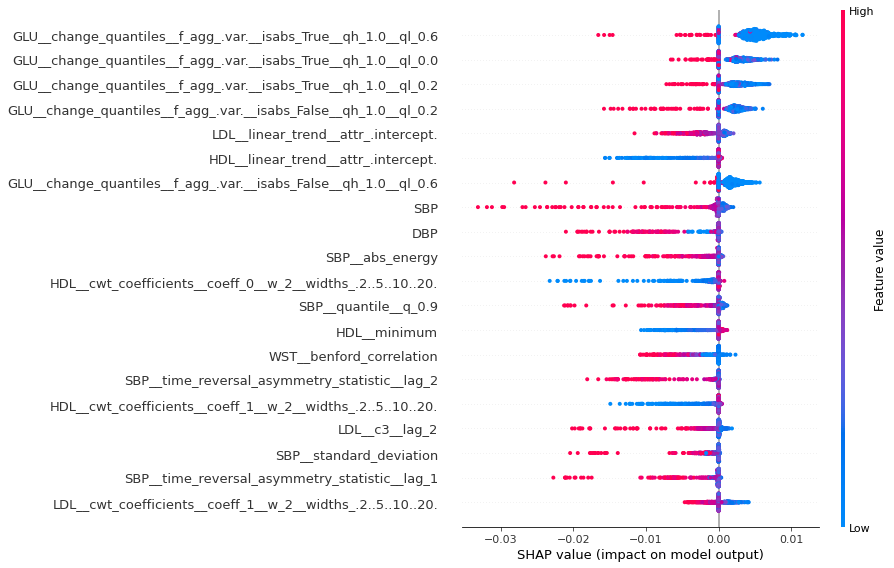

In [41]:
shap.initjs()
shap.summary_plot(old_kmeans_shaps.to_numpy(), featurespace_test_df)


In [ ]:
# import pickle 
# file_explainer_kmeans = open(savedir+'/'+'file_explainer_kmeans.obj', 'wb') 
# pickle.dump(explainer_kmeans, file_explainer_kmeans)



In [ ]:
# import pickle 

# load_kmeans_shaps = pickle.load(open(savedir+'/'+'file_kmeans_shaps.obj', 'r'))

In [43]:
explainer_kmeans_expected_value = 0.9826951522980154

In [64]:
shap.initjs()
shap.force_plot(explainer_kmeans_expected_value, kmeans_shaps[0],featurespace_test_df.iloc[0,:])


In [65]:
shap.initjs()
shap.force_plot(explainer_kmeans_expected_value, kmeans_shaps[8],featurespace_test_df.iloc[8,:])


In [69]:
shap.initjs()
shap.force_plot(explainer_kmeans_expected_value, kmeans_shaps[41],featurespace_test_df.iloc[41,:])


In [71]:
shap.force_plot(explainer_kmeans_expected_value, kmeans_shaps[68],featurespace_test_df.iloc[68,:])


In [ ]:
kmeans_shaps_wo_var_oi, featurespace_test_df_wo_var_oi_rename

In [ ]:
kmeans_shaps.shape

In [ ]:
featurespace_test_df.shape

In [18]:
featurespace_test_df['GLU__change_quantiles__f_agg_.var.__isabs_True__qh_1.0__ql_0.6'].corr(featurespace_test_df['GLU__change_quantiles__f_agg_.var.__isabs_True__qh_1.0__ql_0.0'])


0.6696727706401225

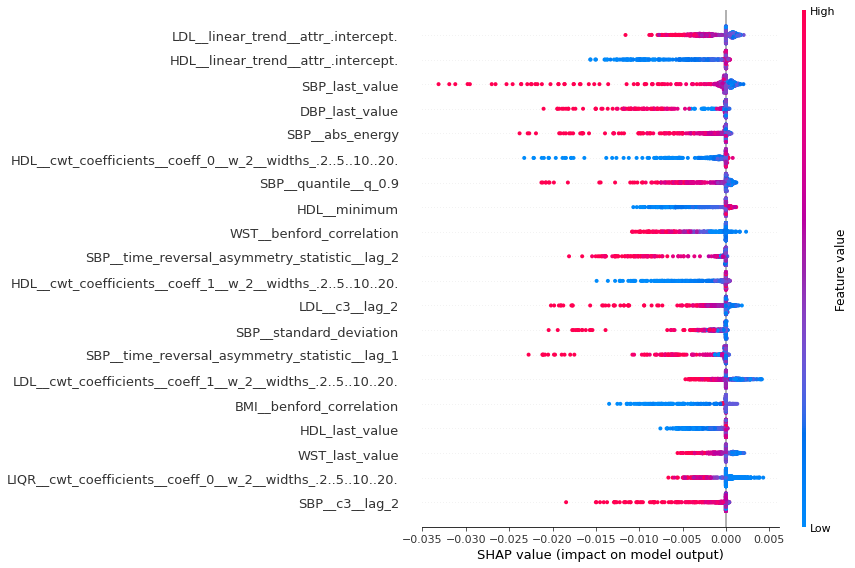

In [57]:
shap.initjs()

idx_glu = featurespace_test_df.columns.get_loc('GLU__change_quantiles__f_agg_.var.__isabs_True__qh_1.0__ql_0.6')
idx_glu2 = featurespace_test_df.columns.get_loc('GLU__change_quantiles__f_agg_.var.__isabs_True__qh_1.0__ql_0.0')
idx_glu3 = featurespace_test_df.columns.get_loc('GLU__change_quantiles__f_agg_.var.__isabs_True__qh_1.0__ql_0.2')
idx_glu4 = featurespace_test_df.columns.get_loc('GLU__change_quantiles__f_agg_.var.__isabs_False__qh_1.0__ql_0.2')
idx_glu5 = featurespace_test_df.columns.get_loc('GLU__change_quantiles__f_agg_.var.__isabs_False__qh_1.0__ql_0.6')

kmeans_shaps_wo_var_oi = np.delete(kmeans_shaps, [idx_glu, idx_glu2, idx_glu3, idx_glu4, idx_glu5], 1)
featurespace_test_df_wo_var_oi = featurespace_test_df.drop(featurespace_test_df.columns[[idx_glu, idx_glu2, idx_glu3, idx_glu4, idx_glu5]], axis=1)

featurespace_test_df_wo_var_oi_rename = featurespace_test_df_wo_var_oi.rename(columns={'SBP': 'SBP_last_value'
                                                                                       , 'DBP': 'DBP_last_value'
                                                                                       , 'HDL': 'HDL_last_value'
                                                                                       , 'WST': 'WST_last_value'
                                                                                      })

shap.summary_plot(kmeans_shaps_wo_var_oi, featurespace_test_df_wo_var_oi_rename)


In [ ]:
# shap.initjs()

shap.summary_plot(kmeans_shaps, featurespace_test_df.iloc[:,:], plot_type = 'bar')


In [ ]:
# new:
vimp_shap_kmeans.variable_name[:30].values

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


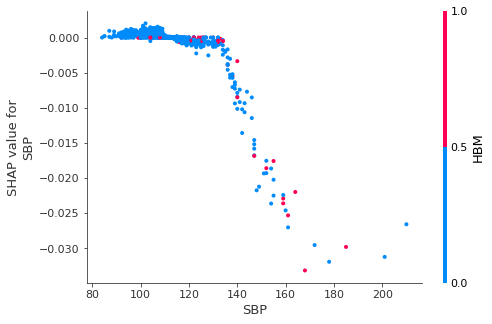

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


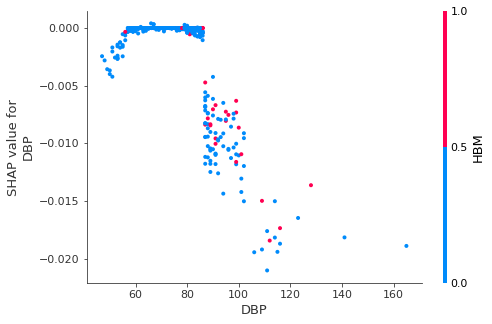

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


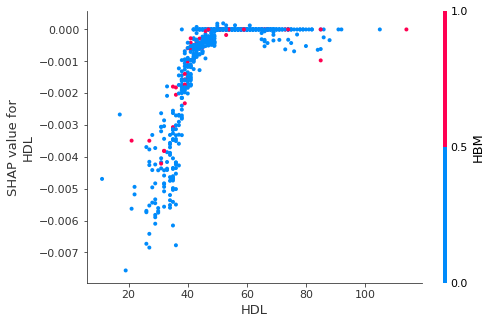

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


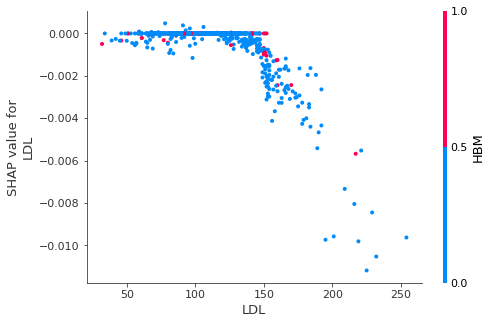

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


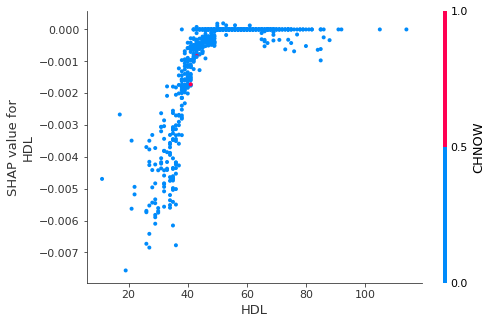

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


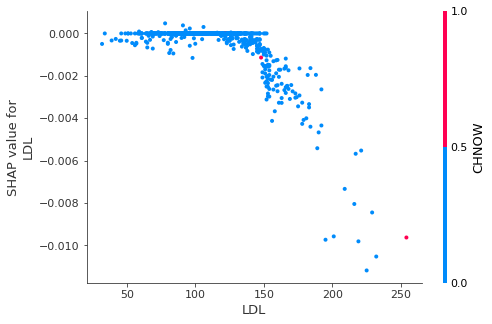

In [36]:
shap.dependence_plot("SBP", kmeans_shaps, featurespace_test_df,interaction_index='HBM')
shap.dependence_plot("DBP", kmeans_shaps, featurespace_test_df,interaction_index='HBM')
shap.dependence_plot("HDL", kmeans_shaps, featurespace_test_df,interaction_index='HBM')
shap.dependence_plot("LDL", kmeans_shaps, featurespace_test_df,interaction_index='HBM')
shap.dependence_plot("HDL", kmeans_shaps, featurespace_test_df,interaction_index='CHNOW')
shap.dependence_plot("LDL", kmeans_shaps, featurespace_test_df,interaction_index='CHNOW')

In [ ]:
# shap.dependence_plot("SBP__standard_deviation", kmeans_shaps, featurespace_test_df,interaction_index=None)


In [ ]:
# # old:
# top_n_var = 20
# top_var_names_arr = vimp_shap_kmeans.variable_name[:top_n_var].values
# for i in range(top_n_var):
#     var_oi = top_var_names_arr[i]
#     shap.dependence_plot(var_oi, kmeans_shaps, featurespace_test_df,interaction_index=None)



In [ ]:
# import matplotlib.pyplot as plt
# kmeans_shaps[:,idx_glu].shape
# featurespace_test_df.iloc[:, idx_glu].shape
# plt.scatter(featurespace_test_df.iloc[:, idx_glu], kmeans_shaps[:,idx_glu])

In [ ]:
test_df

In [ ]:
df_for_bc.loc[df_for_bc[featurespace_test_df.columns[idx_oi]] > 5000]

In [ ]:
data_full.loc[data_full['ID'].isin(testingid),:].loc[featurespace_test_df['GLU__change_quantiles__f_agg_.var.__isabs_True__qh_1.0__ql_0.6'] > 5000]

In [ ]:

# import plotly.graph_objects as go

# fig_scatter = px.scatter(df_for_bc
#     , x= featurespace_test_df.columns[idx_oi]
#     , y='SHAP value'
#     , size='time'
#     , color='event'
#                  #hover_name="country"
#                  #, log_x=True,                               
#                  , size_max=10
                
#                 )

# fig = go.Figure(data=[go.Scatter(
#     df_for_bc.to_dict()
#     , x= featurespace_test_df.columns[idx_oi]
#     , y='SHAP value'
#     , size='time'
#     , color='event'
    
#     , mode='markers',
#     marker=dict(
#         color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)',
#                'rgb(44, 160, 101)', 'rgb(255, 65, 54)'],
#         opacity=[1, 0.8, 0.6, 0.4],
#         size=[40, 60, 80, 100],
#     )
# )])

# fig.show()


# fig.show()

In [ ]:
## Bubble Chart:


idx_SBP = featurespace_test_df.columns.get_loc('SBP')


idx_oi = idx_SBP
df_for_bc = pd.DataFrame({featurespace_test_df.columns[idx_oi]:featurespace_test_df.iloc[:, idx_oi]
                         , 'SHAP value': kmeans_shaps[:,idx_oi]
                         , 'event': test_df.event.values
                         , 'time': test_df.time.values})
df_for_bc['Event'] = df_for_bc['event'].astype('category')

# df_for_bc['invert_time'] = swap_relative_values(df_for_bc['time'])
df_for_bc['invert_time'] = -(df_for_bc['time'])
df_for_bc['Time (months)'] = -(df_for_bc['time'])


import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)}, font_scale = 2, style = 'whitegrid')
#sns.set()
#fig, ax = plt.subplots(figsize=(10, 10))

bc_plot = sns.scatterplot(data=df_for_bc
                , x=featurespace_test_df.columns[idx_oi]
                , y='SHAP value'
                , size= 'Time (months)'
                , hue='Event', palette = ['dodgerblue', 'crimson']
                , alpha=0.4, sizes=(40, 800)
                # , ax = ax
                , legend = False
                )
# plt.legend(loc = 'center left', markerscale = 2
#            , bbox_to_anchor = (1, 0.5))

plt.show()



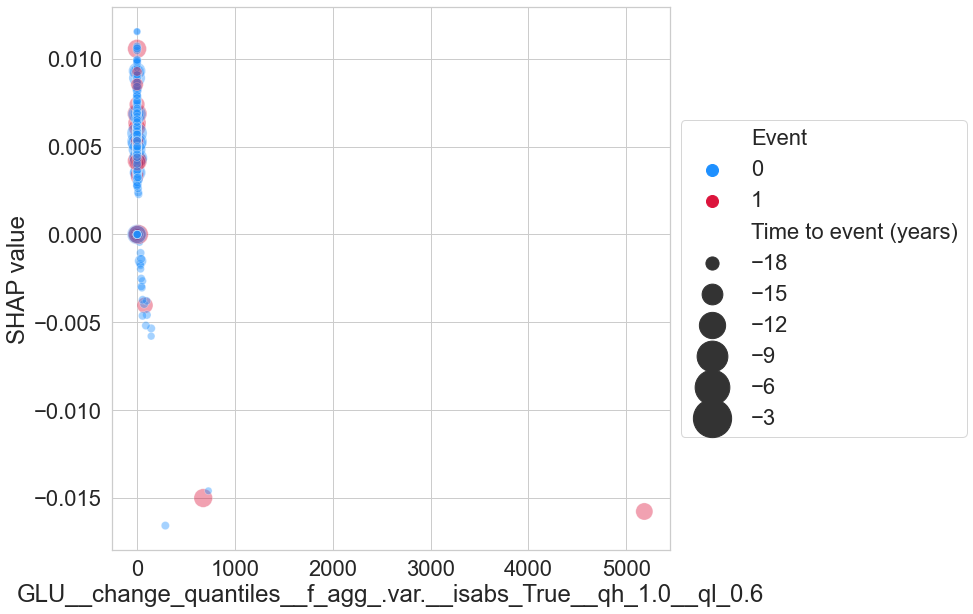

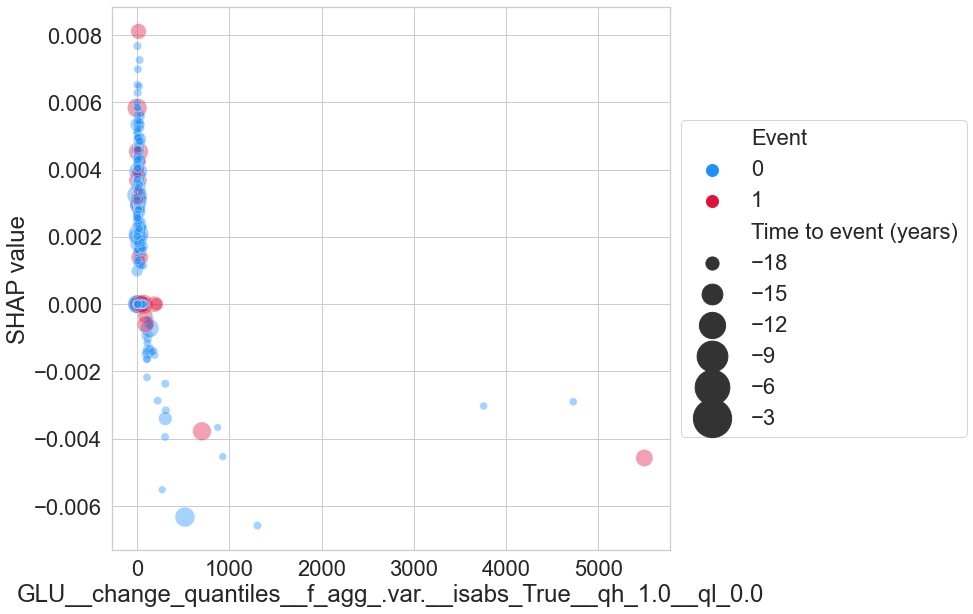

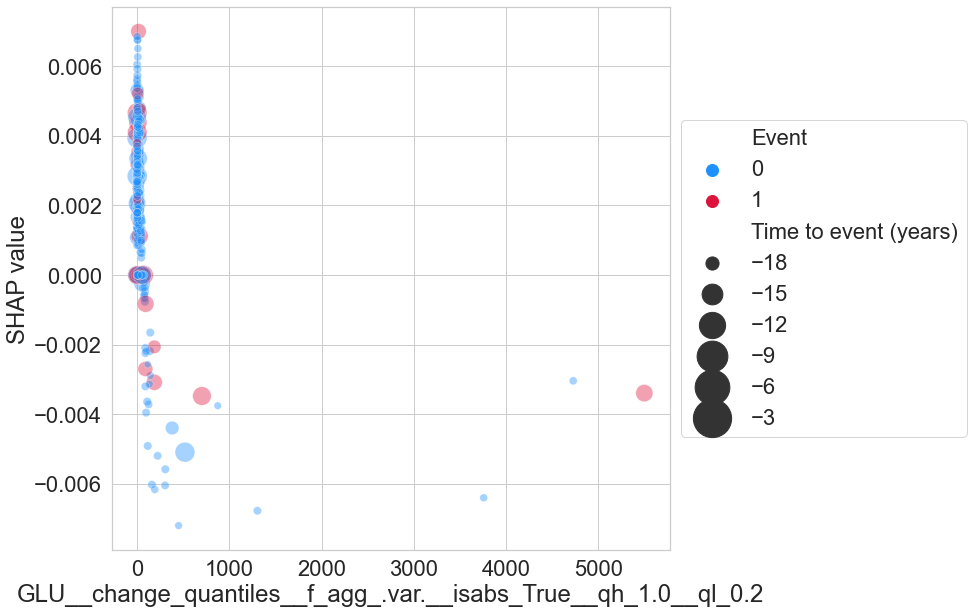

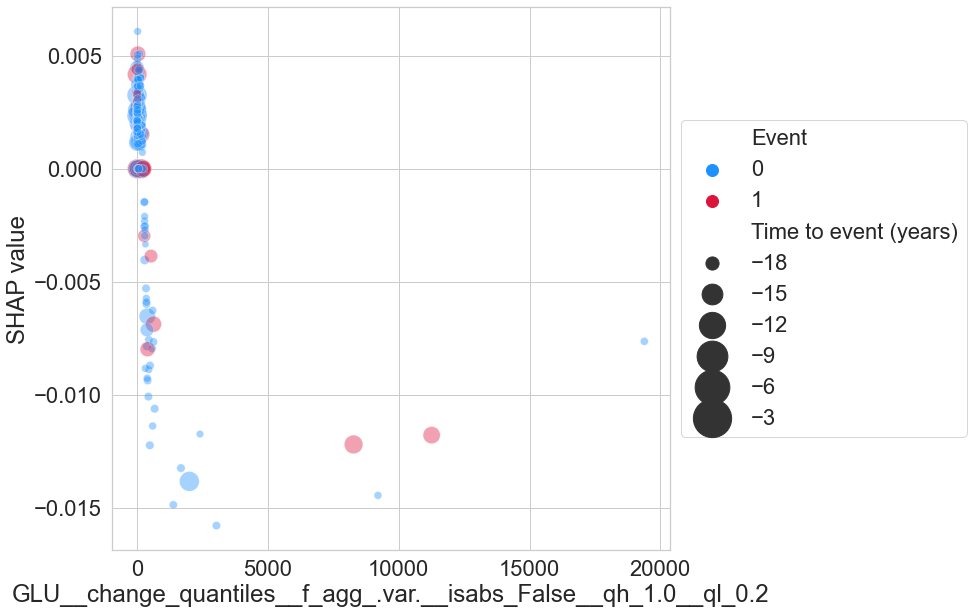

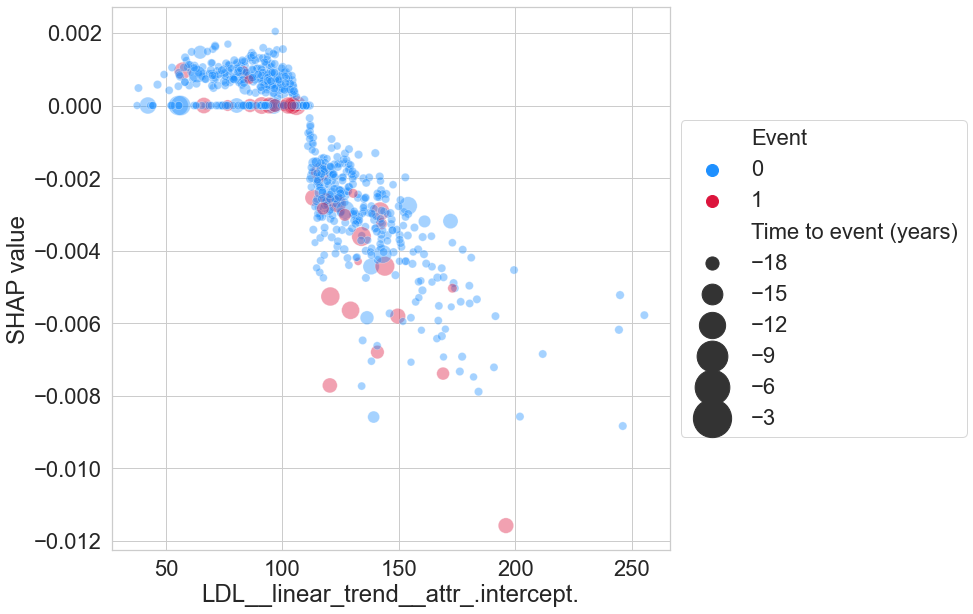

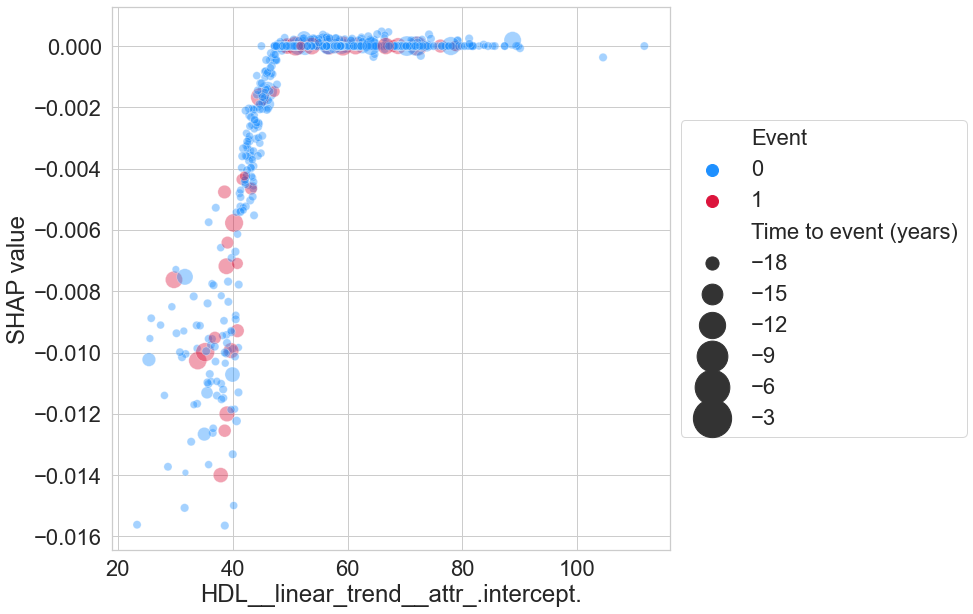

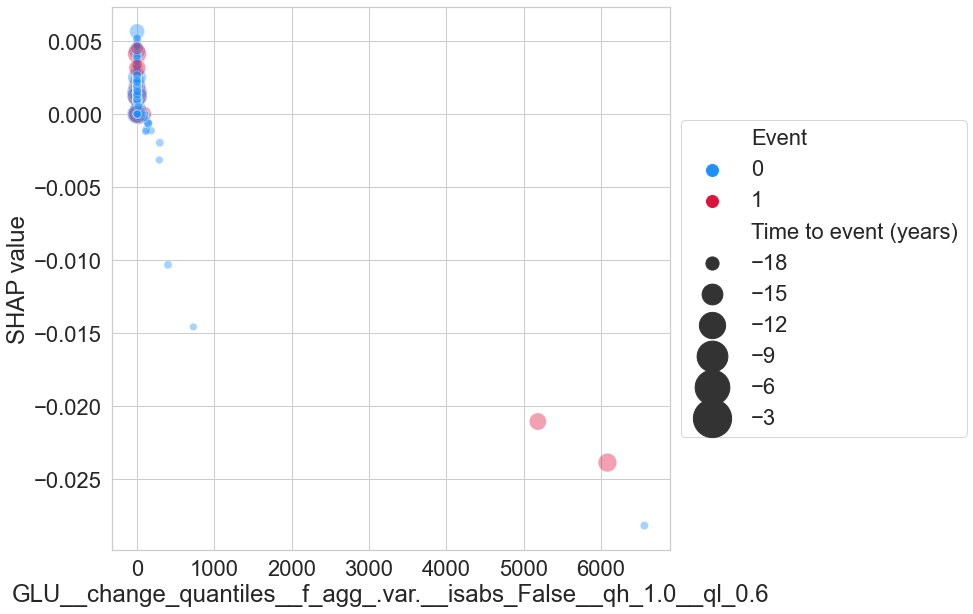

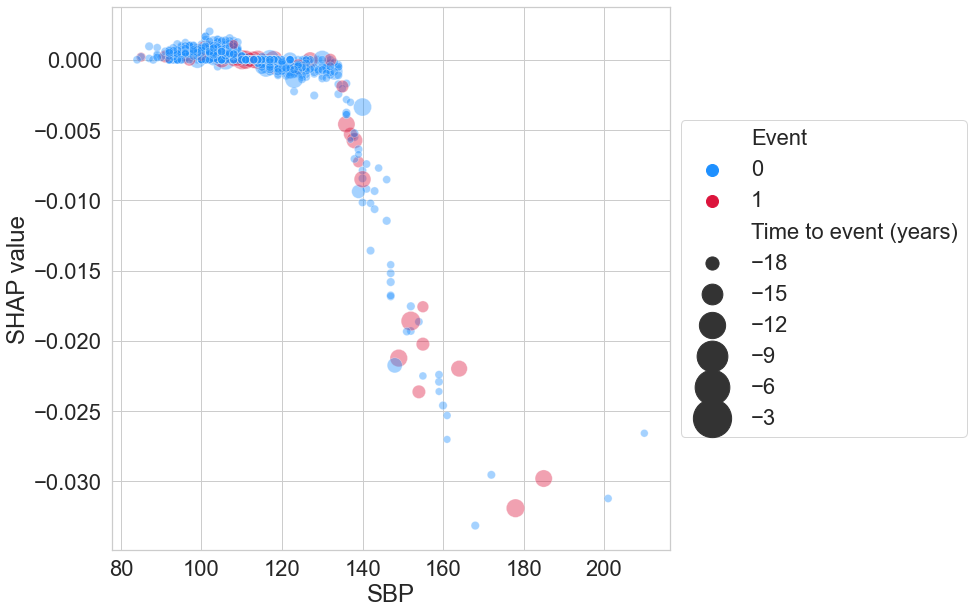

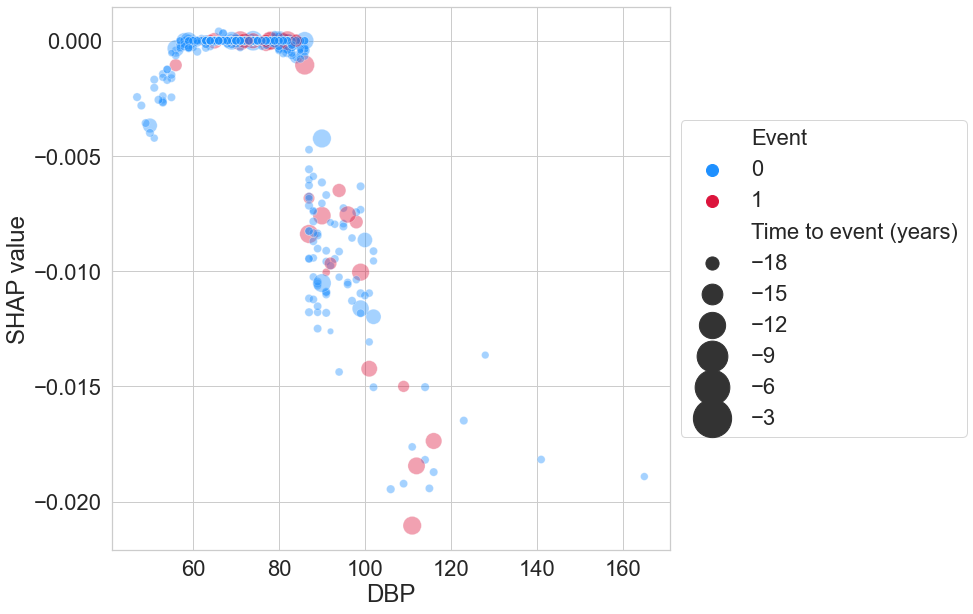

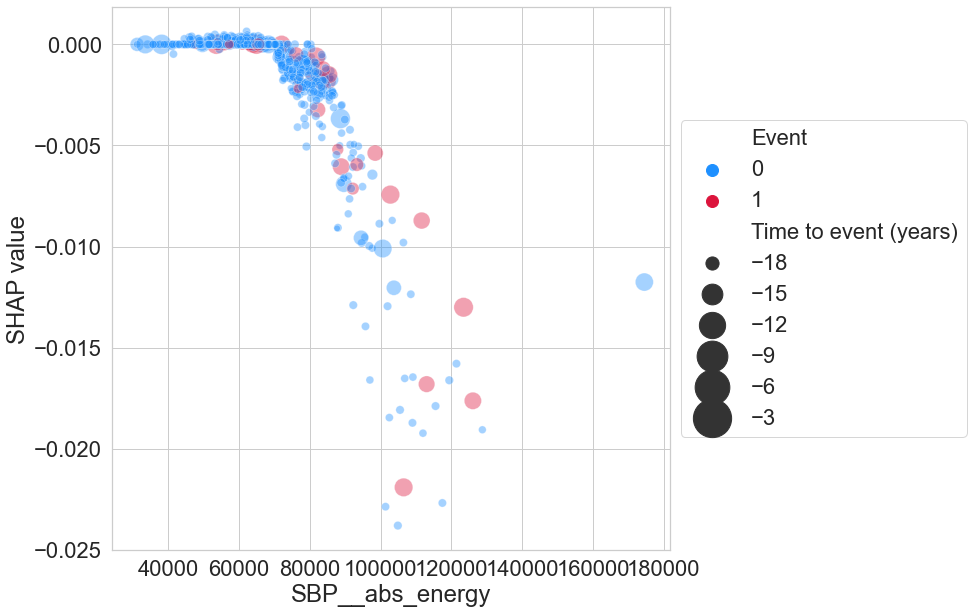

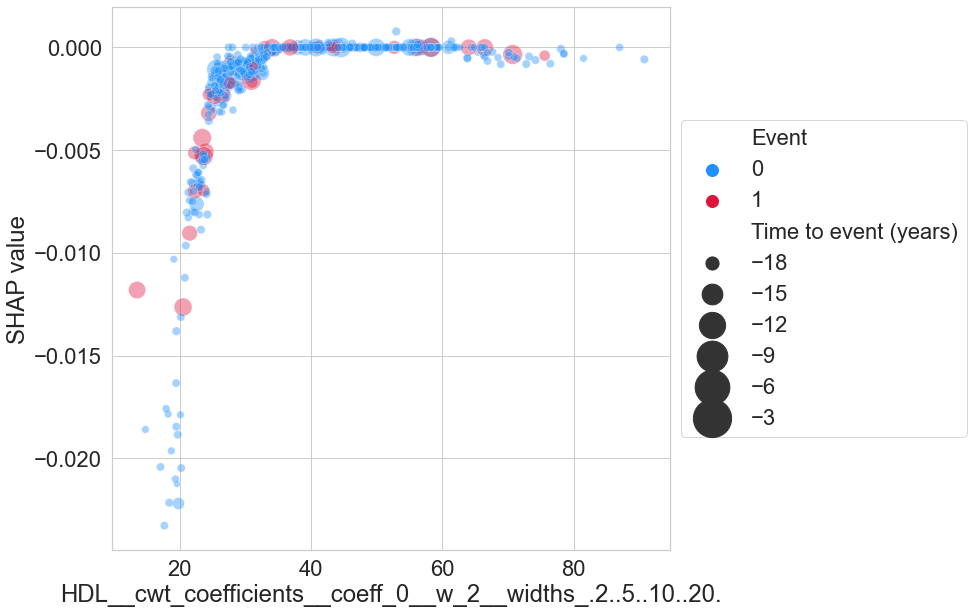

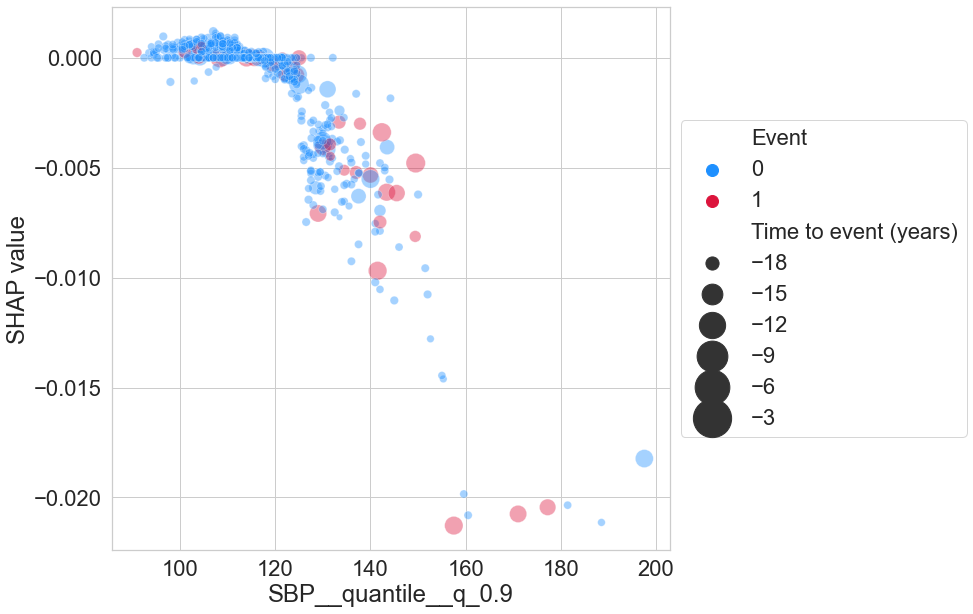

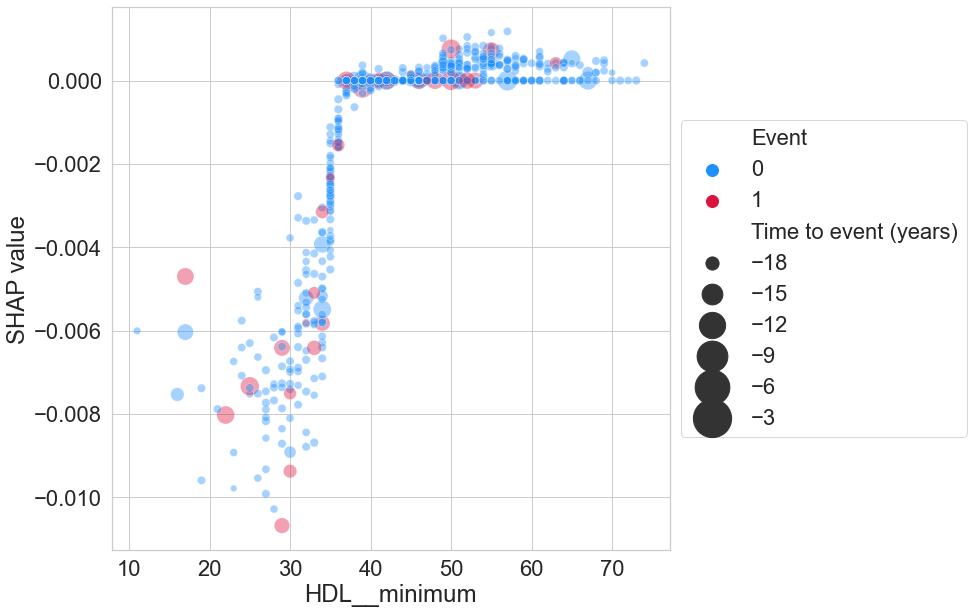

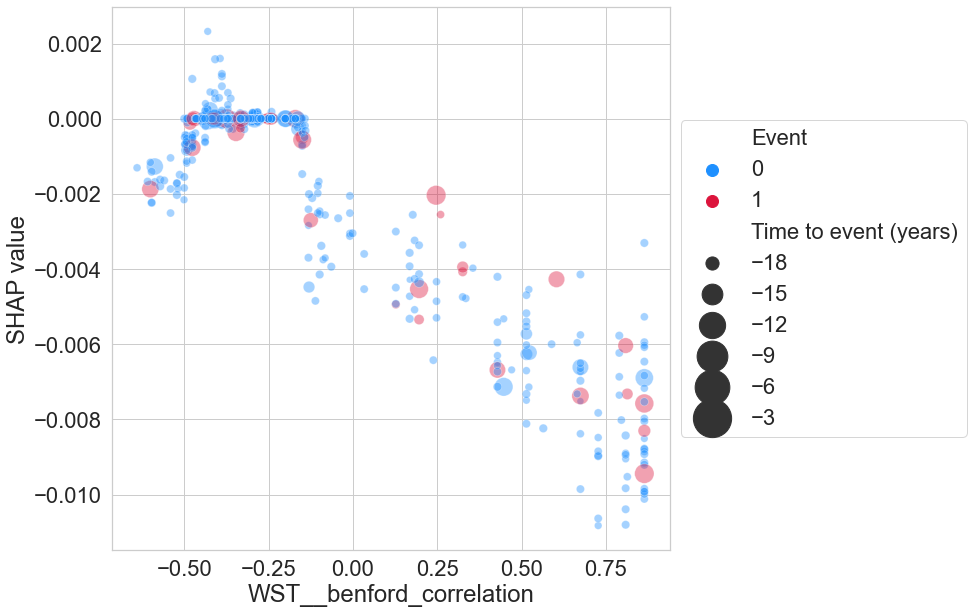

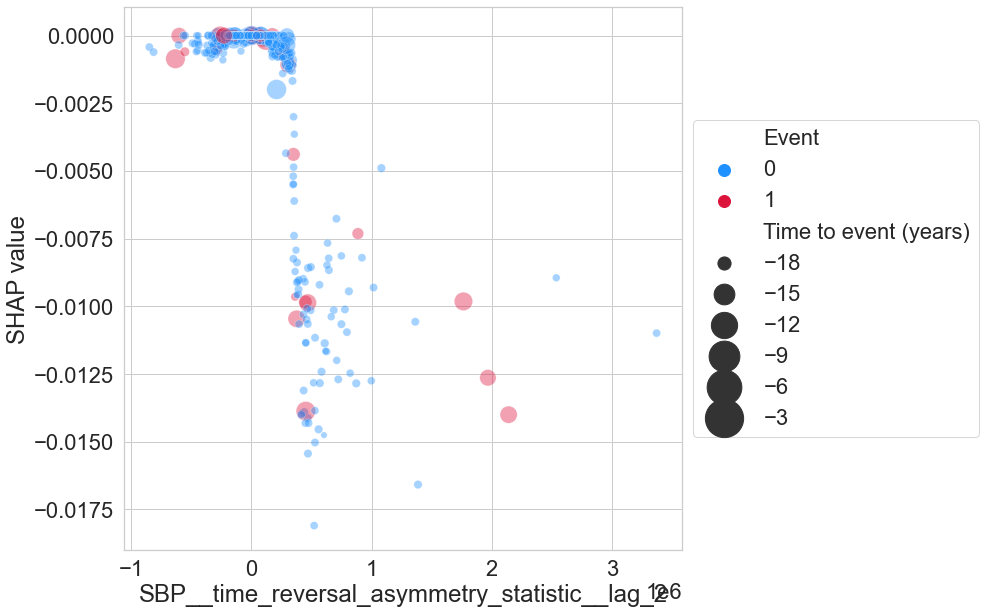

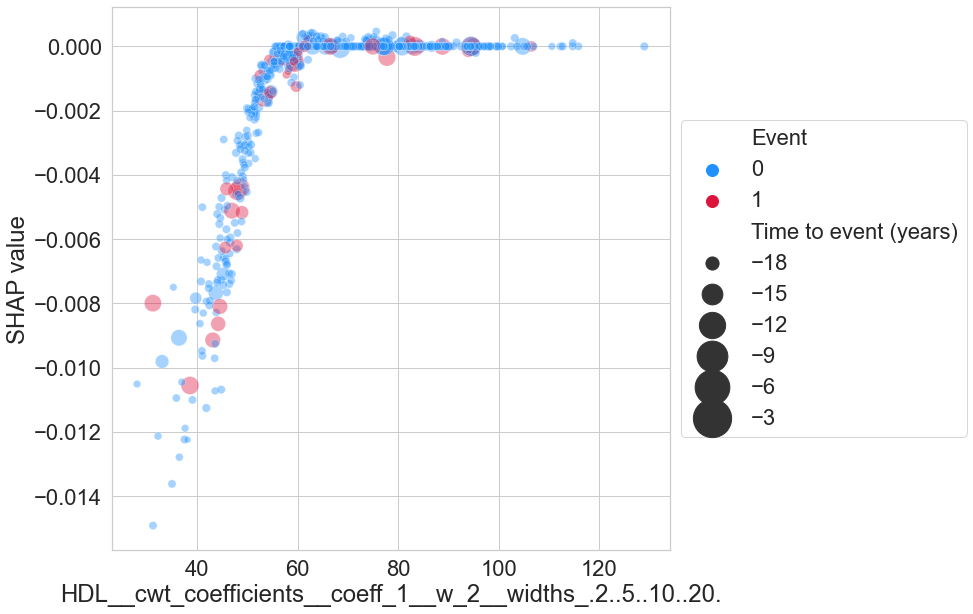

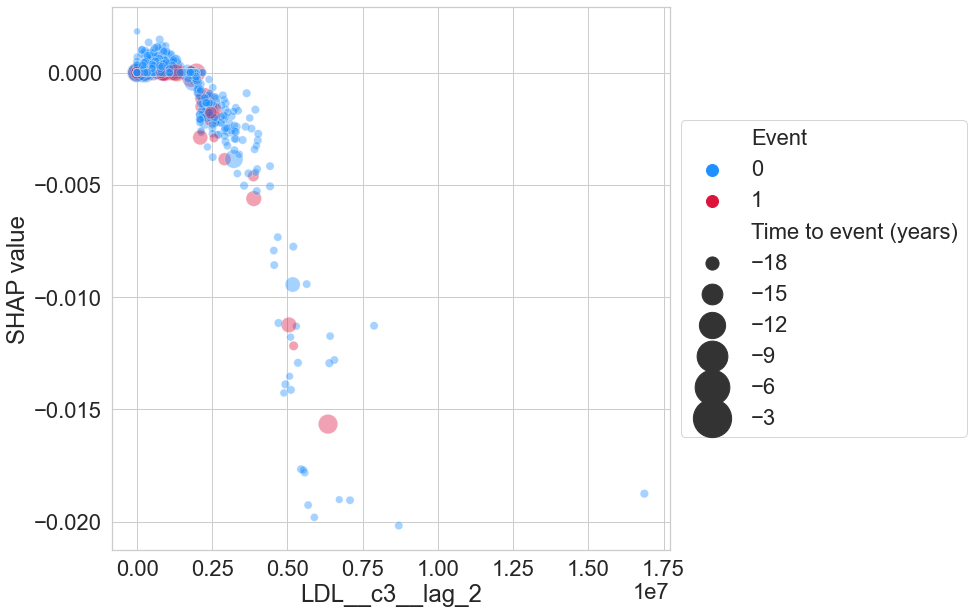

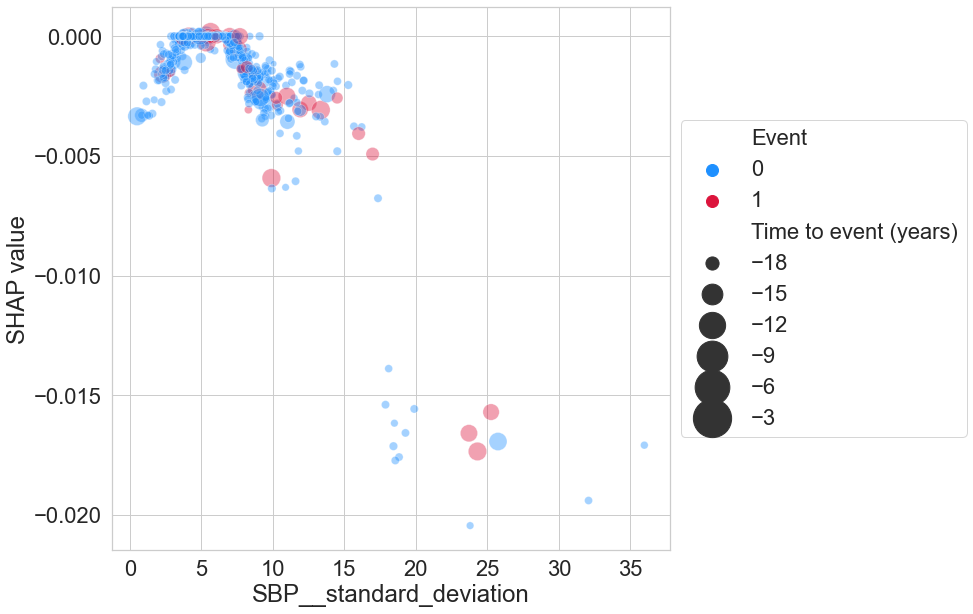

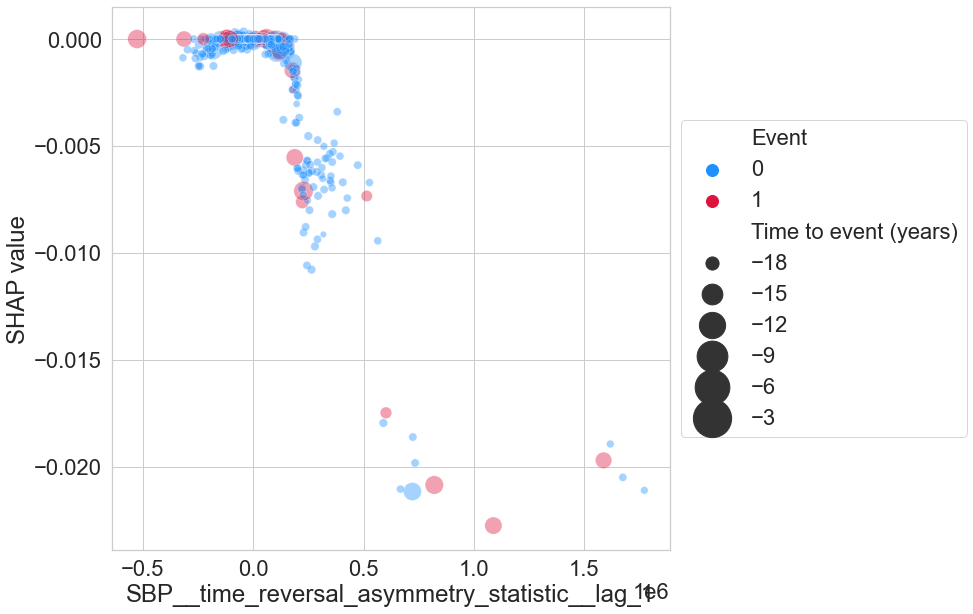

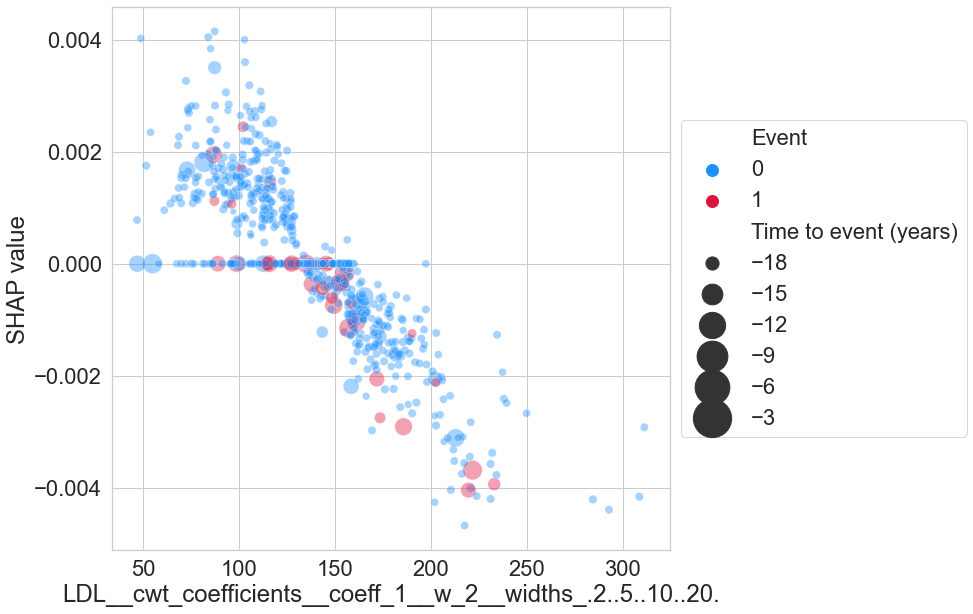

In [337]:
## Bubble Chart:

def plot_bubble_chart_SHAP(df, var):

    idx_oi = df.columns.get_loc(var)
    df_for_bc = pd.DataFrame({df.columns[idx_oi]:df.iloc[:, idx_oi]
                             , 'SHAP value': kmeans_shaps[:,idx_oi]
                             , 'event': test_df.event.values
                             , 'time': test_df.time.values})
    df_for_bc['Event'] = df_for_bc['event'].astype('category')

    df_for_bc['invert_time'] = -(df_for_bc['time'])
    df_for_bc['Time to event (years)'] = -(df_for_bc['time'])
    df_for_bc['Time to event (years)'] = -(df_for_bc['time'])


    import seaborn as sns
    sns.set(rc={'figure.figsize':(10,10)}, font_scale = 2, style = 'whitegrid')
    #sns.set()
    #fig, ax = plt.subplots(figsize=(10, 10))
    
    bc_plot = sns.scatterplot(data=df_for_bc
                    , x=df.columns[idx_oi]
                    , y='SHAP value'
                    , size= 'Time to event (years)'
                    , hue='Event', palette = ['dodgerblue', 'crimson']
                    , alpha=0.4, sizes=(40, 400)
                    # , ax = ax
                    #, legend = False
                    # , label = str(Time_in_years) + ' years'
                    )
    plt.legend(loc = 'center left', markerscale = 2
               , bbox_to_anchor = (1, 0.5))

    plt.show()


top_n_var = 20
top_var_names_arr = vimp_shap_kmeans.variable_name[:top_n_var].values
for i in range(top_n_var):
    plot_bubble_chart_SHAP(featurespace_test_df, top_var_names_arr[i])
    

In [ ]:
# top_n_var = 20
# top_var_names_arr = vimp_shap_kmeans.variable_name[:top_n_var].values
# for i in range(top_n_var):
#     var_oi = top_var_names_arr[i]
#     shap.dependence_plot(var_oi, kmeans_shaps, featurespace_test_df,interaction_index=None)

